# Modelagem

Este notebook documenta o processo de modelagem dos dados de geração de energia solar utilizando o modelo LightGBM. Inclui as etapas de preparação dos dados, treinamento do modelo, avaliação e visualização dos resultados.

## Importação de Bibliotecas Necessárias

In [1]:
import os # Biblioteca para manipulação de arquivos e diretórios
import sys # Biblioteca para manipulação de caminhos do sistema
import pandas as pd # Biblioteca para manipulação de dataframes
import numpy as np # Biblioteca para manipulação de vetores e matrizes
import geopandas as gpd # Biblioteca para manipulação de geodataframes
import matplotlib.pyplot as plt # Biblioteca para plotar gráficos
import seaborn as sns # Biblioteca para plotar gráficos
import lightgbm as lgb # Biblioteca para modelagem

from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Ajuste do sys.path para incluir o diretório src
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Importar funções específicas do projeto
# from modeling import *
from database import create_connection, query_data

## Carregar Dados

Carrega o arquivo CSV contendo os dados preprocessados.

In [2]:
# Carregar base de dados
current_dir = os.getcwd()  # Diretório de trabalho atual, que é dentro de 'data'
repository_dir = os.path.abspath(os.path.join(current_dir, '..'))  # Voltar um nível para o diretório do repositório
file_path = os.path.join(repository_dir, 'data', 'processed', 'base_de_dados_preprocessada.csv')  # Caminho para o arquivo de dados
df = pd.read_csv(file_path, delimiter=',')

# Display
df.head()

,data_hora_completa,ceg,estacao,radiacao_global,temperatura_ar,umidade_relativa,velocidade_vento,val_geracao
0,2023-01-31 00:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.401146,0.836957,0.022727,0.0
1,2023-01-31 01:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.386819,0.880435,0.136364,0.0
2,2023-01-31 02:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.392550,0.815217,0.090909,0.0
3,2023-01-31 03:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.401146,0.793478,0.053030,0.0
4,2023-01-31 04:00:00,UFV.RS.MG.040851-4.01,ARAXA,0.000043,0.398281,0.771739,0.007576,0.0


## Treinamento

### Separação dos Dados

Extrai informações temporais e separa os dados em features (X) e target (y), além de codificar variáveis categóricas e dividir os dados em conjuntos de treino e teste.

In [3]:
# Converte a coluna data_hora_completa para o tipo datetime e extrai informações temporais.
df['data_hora_completa'] = pd.to_datetime(df['data_hora_completa'])
df['year'] = df['data_hora_completa'].dt.year
df['month'] = df['data_hora_completa'].dt.month
df['day'] = df['data_hora_completa'].dt.day
df['hour'] = df['data_hora_completa'].dt.hour
df['day_of_week'] = df['data_hora_completa'].dt.dayofweek

# Dates
dates = df['data_hora_completa']

In [4]:
# Definir variáveis independentes
X = df.drop(columns=['data_hora_completa', 'ceg', 'estacao', 'val_geracao'])

# Definir variável dependente
y = df['val_geracao']

# Print
print("Variáveis independentes:")
print(X.head())

print("\nVariável dependente:")
print(y.head())

Variáveis independentes:
   radiacao_global  temperatura_ar  umidade_relativa  velocidade_vento  year  \
0         0.000043        0.401146          0.836957          0.022727  2023   
1         0.000043        0.386819          0.880435          0.136364  2023   
2         0.000043        0.392550          0.815217          0.090909  2023   
3         0.000043        0.401146          0.793478          0.053030  2023   
4         0.000043        0.398281          0.771739          0.007576  2023   

   month  day  hour  day_of_week  
0      1   31     0            1  
1      1   31     1            1  
2      1   31     2            1  
3      1   31     3            1  
4      1   31     4            1  

Variável dependente:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: val_geracao, dtype: float64


### Codificação One-Hot

Para que o modelo de machine learning possa utilizar variáveis categóricas (como mês, dia, hora e dia da semana), é necessário transformá-las em uma representação numérica. A codificação One-Hot é uma técnica que cria novas colunas binárias (0 ou 1) para cada valor único nas variáveis categóricas.

Por exemplo, a variável month terá 12 novas colunas, uma para cada mês, onde o valor será 1 se o mês corresponder ao mês da coluna, e 0 caso contrário. Esta transformação é fundamental para que os modelos de machine learning possam interpretar corretamente essas variáveis.

In [5]:
# Definir variáveis independentes
categorical_features = ['month', 'day', 'hour', 'day_of_week']

# Transformar variáveis categóricas em variáveis dummy
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Print
print("Variáveis independentes:")
print(X_encoded.head())

Variáveis independentes:
   radiacao_global  temperatura_ar  umidade_relativa  velocidade_vento  year  \
0         0.000043        0.401146          0.836957          0.022727  2023   
1         0.000043        0.386819          0.880435          0.136364  2023   
2         0.000043        0.392550          0.815217          0.090909  2023   
3         0.000043        0.401146          0.793478          0.053030  2023   
4         0.000043        0.398281          0.771739          0.007576  2023   

   month_1  month_2  month_3  month_4  month_5  ...  hour_21  hour_22  \
0     True    False    False    False    False  ...    False    False   
1     True    False    False    False    False  ...    False    False   
2     True    False    False    False    False  ...    False    False   
3     True    False    False    False    False  ...    False    False   
4     True    False    False    False    False  ...    False    False   

   hour_23  day_of_week_0  day_of_week_1  day_of_week_2

### Divisão dos Dados em Conjuntos de Treino e Teste
Dividimos os dados em conjuntos de treino e teste para avaliar o desempenho do modelo.

In [6]:
# Dividir a base de dados em treino e teste, com 80% dos dados para treino e 20% para teste
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_encoded, y, dates, test_size=0.2, random_state=42)

### Estimando Parâmetros (Validação Cruzada)
Configura e executa a validação cruzada com Grid Search para encontrar os melhores hiperparâmetros do modelo.

In [7]:
# Usar validação cruzada para encontrar os melhores parâmetros do modelo
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir o modelo
model = lgb.LGBMRegressor()

# Definir o grid de parâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Realizar a busca em grade
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, verbose=1, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:", grid_search.best_params_)
print("Melhor score de validação cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 519936, number of used features: 79
[LightGBM] [Info] Start training from score 0.046135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

### Treinamento
Treina o modelo LightGBM com os melhores hiperparâmetros encontrados.

In [8]:
# Treinar o modelo com os melhores parâmetros encontrados
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

gbm = lgb.train(
    grid_search.best_params_,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

# Fazer previsões
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

C:\Users\afaze\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 519936, number of used features: 79
[LightGBM] [Warning] Provided parameters cons

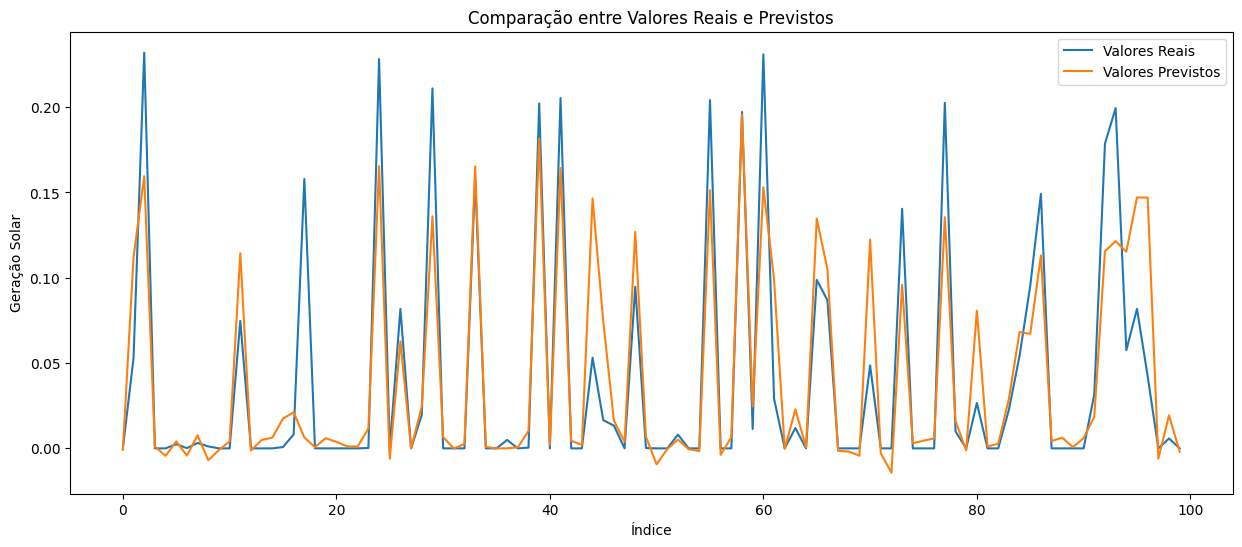

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Valores Reais')
plt.plot(y_pred[:100], label='Valores Previstos')
plt.legend()
plt.xlabel('Índice')
plt.ylabel('Geração Solar')
plt.title('Comparação entre Valores Reais e Previstos')
plt.show()

## Avaliação do Modelo

Avalia o modelo utilizando métricas de erro e plota as predições.

In [10]:
# Calcular métricas finais
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Reoot Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.00121539587485908
Reoot Mean Squared Error: 0.03486252823389434
Mean Absolute Error: 0.020150815642209087
R2 Score: 0.7614542325829218


#### Importância das Features

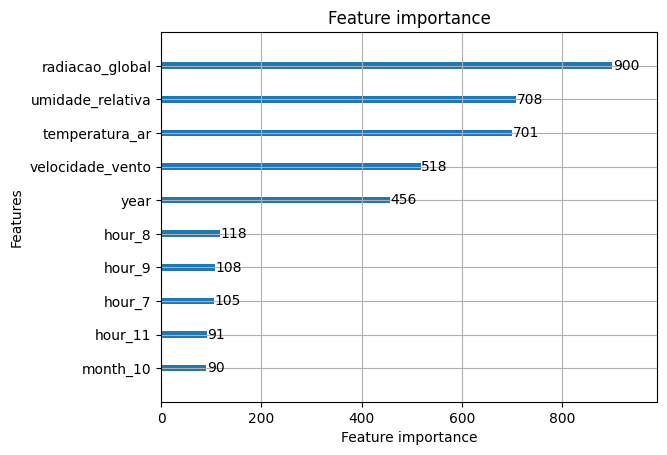

In [11]:
# Plotar importância das variáveis
lgb.plot_importance(gbm, max_num_features=10)
plt.show()

#### Comparação entre Valores Reais e Previstos
Plota gráficos para comparar valores reais e previstos.

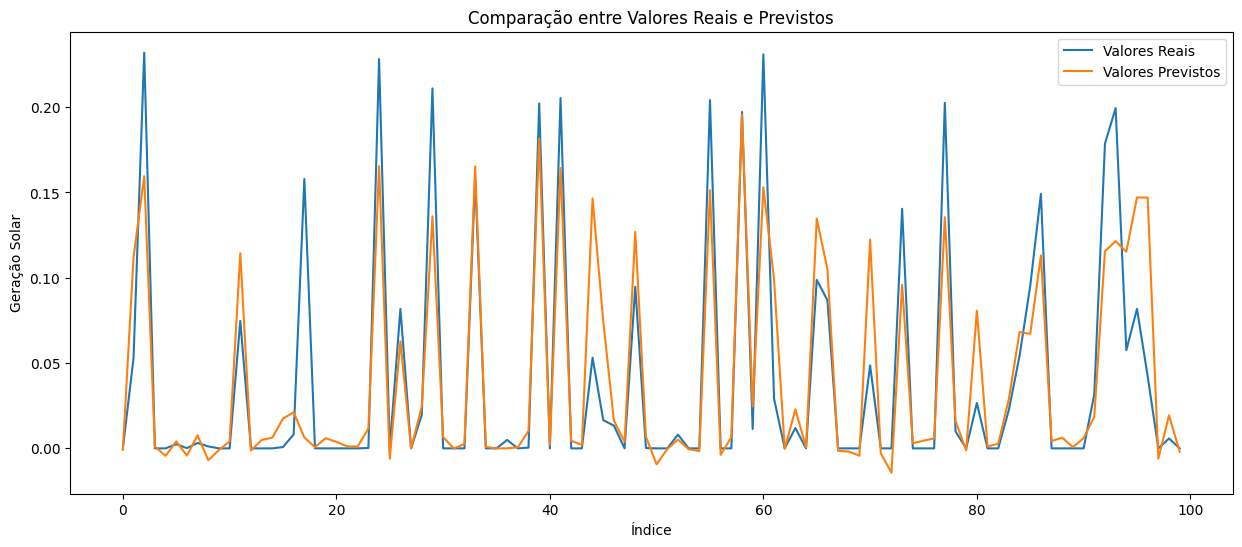

In [12]:
results = pd.DataFrame({
    'date': dates_test,
    'actual': y_test,
    'predicted': y_pred
})

plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Valores Reais')
plt.plot(y_pred[:100], label='Valores Previstos')
plt.legend()
plt.xlabel('Índice')
plt.ylabel('Geração Solar')
plt.title('Comparação entre Valores Reais e Previstos')
plt.show()

Plota o perfil de 24 horas para comparar os valores reais e previstos ao longo do dia.

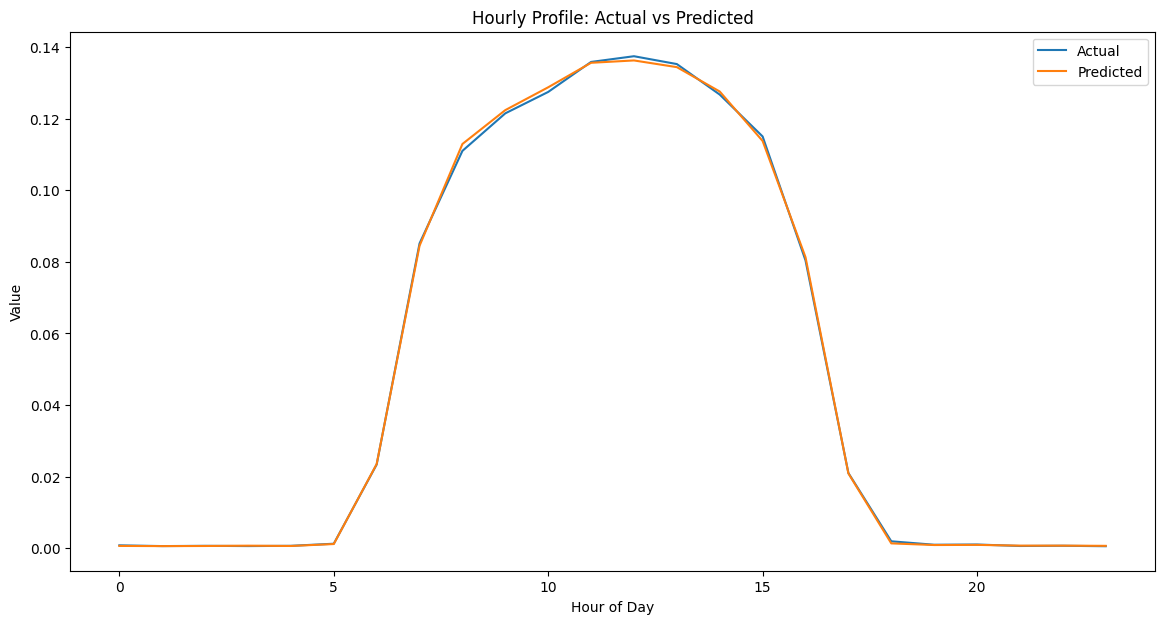

In [13]:
results['hour'] = results['date'].dt.hour
hourly_profile = results.groupby('hour').mean()

plt.figure(figsize=(14, 7))
plt.plot(hourly_profile.index, hourly_profile['actual'], label='Actual')
plt.plot(hourly_profile.index, hourly_profile['predicted'], label='Predicted')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.title('Hourly Profile: Actual vs Predicted')
plt.legend()
plt.show()

O gráfico de resíduos é uma ferramenta fundamental para avaliar a qualidade do modelo de previsão. Resíduos são as diferenças entre os valores reais (observados) e os valores previstos pelo modelo.

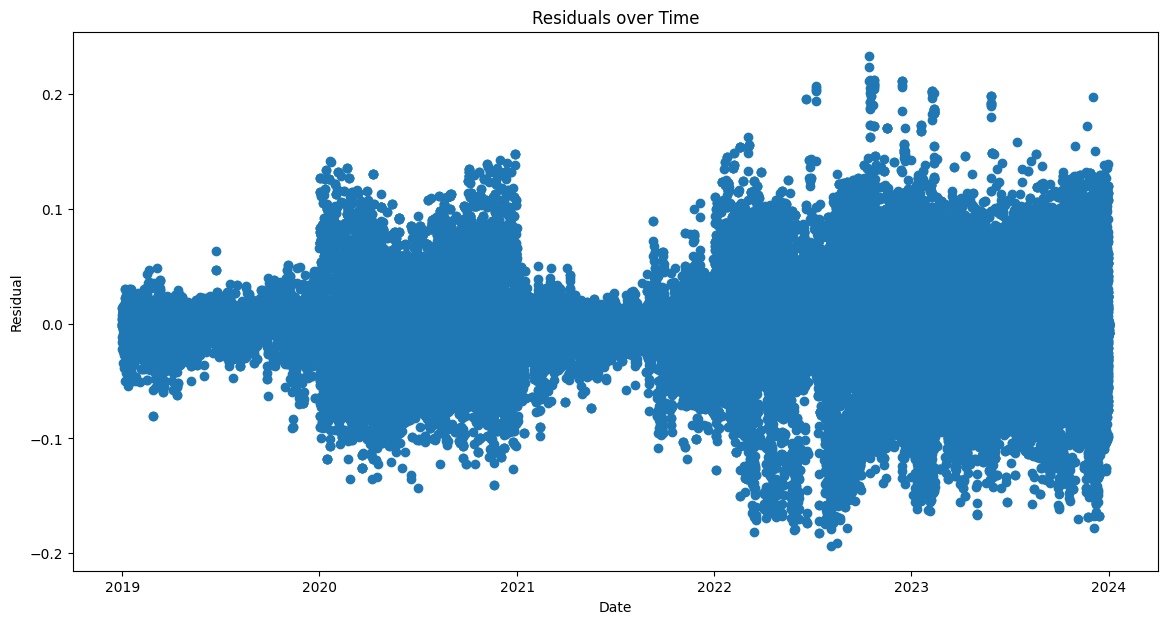

In [14]:
# Gráfico de Resíduos
residuals = results['actual'] - results['predicted']
plt.figure(figsize=(14, 7))
plt.scatter(results['date'], residuals)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals over Time')
plt.show()